## Contents:
- [Imports](#Imports)
- [Prepare Data For EDA and Modeling](#Prepare-Data-For-EDA-and-Modeling)
- [Wildfire Data](#Wildfire-Data)
- [NOAA Weather Data](#NOAA-Weather-Data)
- [Combine Wildfire and NOAA data files](#Combine-Wildfire-and-NOAA-data-files)

# Imports

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Prepare Data For EDA and Modeling

# Wildfire Data

#### Read fire data from SQLlite database into pandas dataframe

In [4]:
# Create the connection
cnx = sqlite3.connect(r'C:/Users/cmrjk/dsi/projects/project_5/data/keggle_fire_data.sqlite')

# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM fires", cnx)

#examine dataframe
df.head(3).T

#### Drop dataframe columns that are outside the scope of the project 

In [6]:
# Create variable with list of unwanted columns
droplist = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID','ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 
            'MTBS_ID', 'MTBS_FIRE_NAME','OWNER_CODE', 'OWNER_DESCR', 'Shape']

# Drop unwanted columns
df.drop(droplist,axis = 1,  inplace=True)

#### Limit states to scope of project

In [ ]:
# Create variable with list of states_of_interest
states_of_interest = ['CA','WA','OR','NV','AZ','NM','UT', 'CO', 'WY', 'ID', 'MT']

#create dataframe with only states_of_interest
fire_df = df[df['STATE'].isin(states_of_interest)]

# Double check that the fire_df contains only states_of_interest
fire_df['STATE'].unique()

#### Datetime conversion and engineer time wildfire burnt feature

In [14]:
#convert datatype to float
fire_df['CONT_DATE'] = fire_df['CONT_DATE'].astype(float)

epoch = pd.to_datetime(0, unit='s').to_julian_date()
fire_df['CONT_DATE_FIXED'] = pd.to_datetime(fire_df['CONT_DATE'] - epoch, unit='D')
fire_df['DISC_DATE_FIXED'] = pd.to_datetime(fire_df['DISCOVERY_DATE'] - epoch, unit='D')

fire_df['TIME_BURNT_FIXED'] = fire_df['CONT_DATE_FIXED'] - fire_df['DISC_DATE_FIXED']

fire_df['TIME_BURNT'] = fire_df['CONT_DATE'] - fire_df['DISCOVERY_DATE']


#### Deal with Nulls

In [ ]:
# Check for nulls
fire_df.isnull().sum()

In [15]:
# Fill null values
fire_df['FIRE_NAME'].fillna('NO_NAME', inplace=True)
fire_df['COMPLEX_NAME'].fillna('NO_NAME', inplace=True)
fire_df['FIRE_CODE'].fillna('NA', inplace=True)
fire_df['FIPS_CODE'].fillna('0', inplace=True)

#create variable of features to drop that are outside the scope of the project
droplist = ['CONT_DOY','CONT_TIME', 'COUNTY', 'FIPS_NAME', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
           'CONT_DATE', 'DISCOVERY_DATE']

#drop date and location columns no longer needed
fire_df.drop(droplist, axis = 1, inplace=True)


#### Lowercase column names

In [16]:
# lowercase columns
fire_df.rename(columns = {col: col.strip().lower() for col in fire_df.columns}, inplace= True)

In [19]:
# examine head of data for a single state
fire_df[fire_df['state']=='CO'].head(3)

,fire_code,fire_name,complex_name,fire_year,stat_cause_code,stat_cause_descr,fire_size,fire_size_class,latitude,longitude,state,fips_code,cont_date_fixed,disc_date_fixed,time_burnt_fixed,time_burnt
47,BEX1,HATCH,NO_NAME,2005,1.0,Lightning,0.5,B,39.292222,-105.183056,CO,0,2005-06-14,2005-06-14,0 days,0.0
61,BEX1,TROUT CREEK II,NO_NAME,2005,1.0,Lightning,0.2,A,38.913333,-105.983611,CO,0,2005-05-31,2005-05-30,1 days,1.0
62,BU9J,MT ELBERT,NO_NAME,2005,4.0,Campfire,0.1,A,39.100278,-106.367500,CO,0,2005-06-21,2005-06-21,0 days,0.0
114,BEX1,8GN,NO_NAME,2005,1.0,Lightning,80.0,C,37.345000,-102.805833,CO,0,2005-07-07,2005-07-07,0 days,0.0
205,BT83,BEAVER,NO_NAME,2005,9.0,Miscellaneous,2.5,B,38.891111,-105.431944,CO,0,2005-06-13,2005-06-13,0 days,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860039,NA,RANGE 135,NO_NAME,2015,13.0,Missing/Undefined,500.0,E,38.609900,-104.807800,CO,041,NaT,2015-09-17,NaT,NaN
1860043,NA,CR 162,NO_NAME,2015,13.0,Missing/Undefined,610.0,E,39.421667,-103.878333,CO,039,NaT,2015-09-15,NaT,NaN
1860044,NA,HIGHWAY 160 MM 291,NO_NAME,2015,13.0,Missing/Undefined,270.0,D,37.545900,-105.007100,CO,055,NaT,2015-10-15,NaT,NaN
1860048,J3Q2,GUTTERSEN RANCH,NO_NAME,2015,13.0,Missing/Undefined,11699.0,G,40.394700,-104.564600,CO,123,NaT,2015-09-18,NaT,NaN


-----



#### Remove Outliers 
Noteably with wildfire time_burnt longer than a year

In [4]:
# Some wildfires in dataset have burned for more than a decade. 
# Examine standard deviations from the mean as a possibile metric for dropping wildfires with excessive/incorrect time_burnt. 
fire_df['time_burnt'].mean() + 10*fire_df['time_burnt'].std()

86.71124807716103

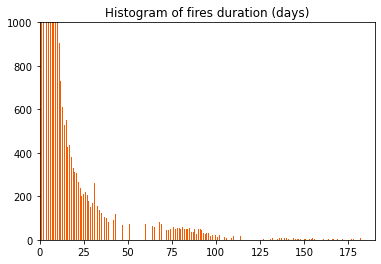

In [5]:
# Let's take a visual look at the distribution of time_burnt
plt.hist(fire_df['time_burnt'], bins = 1000, color = '#F35B04')
plt.ylim(0,1000)
plt.xlim(0,190)
plt.title('Histogram of fires duration (days)');

In [6]:
# The most reasonable way to approach this is to remove wildfires that have burned in excess of a year.
fire_df = fire_df[fire_df['time_burnt'] < 365]

# confirm that dataset includes only fires with time_burnt under a year
fire_df['time_burnt'].max()

#### Save copy of wildfire dataframe to pickle

In [38]:
fire_df.to_pickle('./data/clean_fire_pickle.pkl')

----

#### Create location data for latitude/longitude map and write to file

In [65]:
# Create variable with columns needed for map creation
fire_location = fire_df[['latitude', 'longitude', 'month', 'year', 'fire_size_class']]

# Write location map data to csv
fire_location.to_csv('./data/fire_lat_lon.csv', index=False)

# NOAA Weather Data

#### Read in Weather Data

In [ ]:
# read in data file for cleaning
noaa_data = pd.read_csv('data/noaa_data.csv')

# rename columns for readability
noaa_data.rename(columns = {col: col.strip().lower() for col in noaa_data.columns}, inplace= True)
noaa_data['month'] = noaa_data['yearmonth'].apply(lambda x: str(x)[-2:])
noaa_data['year'] = noaa_data['yearmonth'].apply(lambda x: str(x)[0:4])

#examine first rows of data
noaa_data.head(3)

#### Clean Weather Data columns and examine summary statistics

In [ ]:
# drop unammed index column
noaa_data = noaa_data[[col for col in noaa_data.columns if not 'unnamed' in col]]

# removing two months with placeholder data
noaa_data = noaa_data[(noaa_data['yearmonth']!=202011) & 
                      (noaa_data['yearmonth']!=202012) &
                      (noaa_data['year']>'1900') &
                      (noaa_data['year']>'1900')] 

#examine summary statistics
noaa_data.describe()

#### Write Copy of Cleaned Weather Data to csv

In [ ]:
# write cleaned work to .csv file
noaa_data.to_csv('data/noaa_data_clean.csv', index = False)

# Combine Wildfire and NOAA data files

In [39]:
noaa_clean = pd.read_csv('data/noaa_data_clean.csv')
fire_df = pd.read_pickle('data/clean_fire_pickle.pkl')

print(f'Examine the first columns of fire_df dataframe: {fire_df.head(2)}')
print(f'Examine the first columns of noaa_clean dataframe: {noaa_clean.head(2)}')

,statecode,division,yearmonth,pcp,tavg,pdsi,phdi,zndx,pmdi,cdd,...,sp03,sp06,sp09,sp12,sp24,tmin,tmax,state,month,year
0,2,0,190101,1.21,41.5,-3.55,-3.55,-0.19,-3.55,0,...,-0.15,-0.75,-1.45,-1.20,-2.48,29.3,53.8,AZ,1,1901
1,2,0,190102,2.36,45.3,-2.42,-2.42,2.31,-1.44,5,...,0.28,0.33,-0.62,-0.26,-1.67,34.5,56.1,AZ,2,1901
2,2,0,190103,0.53,48.8,-2.42,-2.42,-0.76,-1.71,14,...,0.60,0.17,-0.65,-0.29,-1.48,34.6,63.0,AZ,3,1901
3,2,0,190104,0.14,54.8,-2.40,-2.40,-0.68,-1.91,51,...,0.42,0.09,-0.36,-0.88,-1.51,39.8,69.8,AZ,4,1901
4,2,0,190105,0.45,65.6,-2.20,-2.20,-0.15,-1.72,200,...,-0.66,-0.08,0.05,-0.77,-1.40,50.5,80.6,AZ,5,1901


In [40]:
print(f'Examine fire_df columns: {fire_df.columns}')
print(f'Examine noaa_clean columns: {noaa_clean.columns}')

Index(['statecode', 'division', 'yearmonth', 'pcp', 'tavg', 'pdsi', 'phdi',
       'zndx', 'pmdi', 'cdd', 'hdd', 'sp01', 'sp02', 'sp03', 'sp06', 'sp09',
       'sp12', 'sp24', 'tmin', 'tmax', 'state', 'month', 'year'],
      dtype='object')

In [41]:
print(f'Examine shape of fire_df file: {fire_df.shape}')
print(f'Examine shape of noaa_clean file: {noaa_clean.shape}')

(15773, 23)

#### Merge wildfire and  file

In [59]:
# Clean Noaa data to only include 1987 - 2015
noaa_clean_yr = noaa_clean[(noaa_clean['year'] > 1986) & (noaa_clean['year'] < 2016)] 

# Create merged data frame with noaa_data years restricted to match fire_df (Plus 5 years)
mfi_df_yr = pd.merge(fire_df, noaa_clean_yr, how ='left', left_on = ['state', 'year', 'month'], right_on = ['state', 'year', 'month'])
mfi_df_yr = mfi_df_yr.drop(columns=['complex_name', 'sp01', 'fips_code', 'fire_name', 'fire_code', 'stat_cause_code'])

In [60]:
# Examine merged dataframe's columns.
mfi_df_yr.columns

Index(['fire_year', 'stat_cause_descr', 'fire_size', 'fire_size_class',
       'state', 'cont_date_fixed', 'disc_date_fixed', 'time_burnt_fixed',
       'time_burnt', 'month', 'year', 'statecode', 'division', 'yearmonth',
       'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'cdd', 'hdd', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax'],
      dtype='object')

#### Examine combined data file. 

In [61]:
mfi_df_yr[(mfi_df_yr['year'] == 2015) & (mfi_df_yr['month'] == 8) & (mfi_df_yr['state'] == 'CA')].head(3)

,fire_year,stat_cause_descr,fire_size,fire_size_class,state,cont_date_fixed,disc_date_fixed,time_burnt_fixed,time_burnt,month,...,cdd,hdd,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
399211,2015,Lightning,120.00,D,CA,2015-08-24,2015-08-12,12 days,12.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
399226,2015,Lightning,0.10,A,CA,2015-08-01,2015-08-01,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
399256,2015,Lightning,0.33,B,CA,2015-08-01,2015-08-01,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
399297,2015,Lightning,0.10,A,CA,2015-08-02,2015-08-01,1 days,1.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
399299,2015,Lightning,0.10,A,CA,2015-08-03,2015-08-03,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419752,2015,Missing/Undefined,0.01,A,CA,2015-08-12,2015-08-12,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
419913,2015,Miscellaneous,0.01,A,CA,2015-08-27,2015-08-27,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
420121,2015,Missing/Undefined,0.40,B,CA,2015-08-16,2015-08-16,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0
420153,2015,Lightning,0.50,B,CA,2015-08-06,2015-08-06,0 days,0.0,8,...,300,1,1.33,0.68,-1.18,-0.74,-0.78,-1.85,62.0,91.0


#### Save combined file to csv

In [ ]:
# github's file upload limit is 100MB, this file is at 89580kb (about 97MB)
mfi_df_yr.to_csv('data/mfi_df_yr_latlong.csv') #commented out so it doesn't run every time